## Cardiovascular Disease Prediction

The purpose of this notebook is to analyse the [Cardiovascular Study Dataset](https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea) and create a logistic regression model predicting  the 10-year risk of coronary heart disease (CHD) based on patient health and lifestyle factors.

**Objective:**  
- Explore and preprocess data  
- Select relevant features  
- Train and evaluate a logistic regression model  
- Choose the optimal classification threshold using an appropriate metric 

The structure is roughly as follows:

1. Data loading and cleaning
2. EDA
3. Modelling

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score


## Data Loading and Cleaning

In [8]:
df = pd.read_csv(r"C:\Users\Namai\Desktop\data analytics\MLproject\train.csv", index_col=0)
df.shape

(3390, 16)

Lets inspect the dataset to see if there are any issues.

In [9]:
df.describe()

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.000000,3303.000000,3368.000000,3346.000000,3390.000000,3390.000000,3390.000000,3352.000000,3390.00000,3390.000000,3376.000000,3389.000000,3086.000000,3390.000000
mean,49.542183,1.970936,9.069477,0.029886,0.006490,0.315339,0.025664,237.074284,132.60118,82.883038,25.794964,75.977279,82.086520,0.150737
std,8.592878,1.019081,11.879078,0.170299,0.080309,0.464719,0.158153,45.247430,22.29203,12.023581,4.115449,11.971868,24.244753,0.357846
min,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.020000,68.000000,71.000000,0.000000
50%,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,56.000000,3.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,28.040000,83.000000,87.000000,0.000000
max,70.000000,4.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.00000,142.500000,56.800000,143.000000,394.000000,1.000000


After reviewing the data, it appears well-structured with no inconsistencies, although there are some missing values.

In [10]:
df.isna().mean().sort_values(ascending=False)

glucose            0.089676
education          0.025664
BPMeds             0.012979
totChol            0.011209
cigsPerDay         0.006490
BMI                0.004130
heartRate          0.000295
age                0.000000
sex                0.000000
is_smoking         0.000000
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
sysBP              0.000000
diaBP              0.000000
TenYearCHD         0.000000
dtype: float64

In [11]:
df.dropna(inplace=True)
df.shape

(2927, 16)

Few columns have missing values so I decided to drop them, because the data will lose only 8.9% of rows in total

In [12]:
df.duplicated().any()


False

There is no duplicate rows

Now let's inspect the categorical variables.

In [13]:
df["sex"].value_counts()

sex
F    1620
M    1307
Name: count, dtype: int64

In [14]:
df["is_smoking"].value_counts()

is_smoking
NO     1480
YES    1447
Name: count, dtype: int64

The categorial variables have no issues. So lets convert them to numeric for futher analysis.

In [15]:
df['sex_num'] = df['sex'].map({'M': 1, 'F': 0})
df['is_smoking_num'] = df['is_smoking'].map({'YES': 1, 'NO': 0})

## Exploratory Data Analysis



The target variable TenYearCHD indicates whether an individual developed coronary heart disease (CHD) within 10 years.

Distribution of CHD cases in the dataset helps us understand whether the data is balanced or imbalanced, which is important for model selection and evaluation.


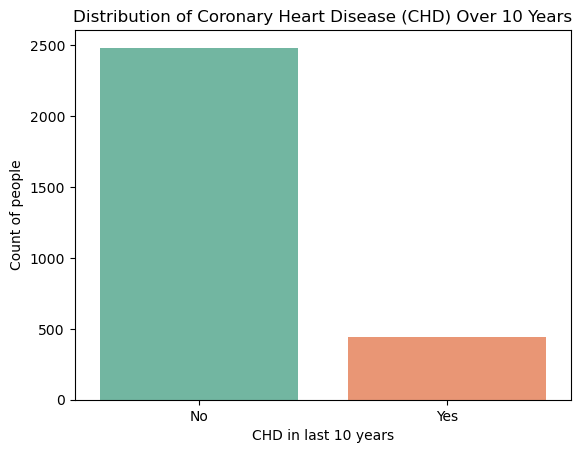

In [16]:
df['CHD'] = df['TenYearCHD'].map({0: 'No', 1: 'Yes'})

sns.countplot(data=df, x='CHD', hue='CHD', palette='Set2', legend=False)
plt.xlabel('CHD in last 10 years')
plt.ylabel('Count of people')
plt.title('Distribution of Coronary Heart Disease (CHD) Over 10 Years')
plt.show()


From the CHD count plot, we observe a significant class imbalance. which means that accuracy will not be an appropriate evaluation metric for this model.

Next section visualizes the distribution of each numeric feature using histograms.

Understanding feature distributions for this model helps identify skewness and general data shape.

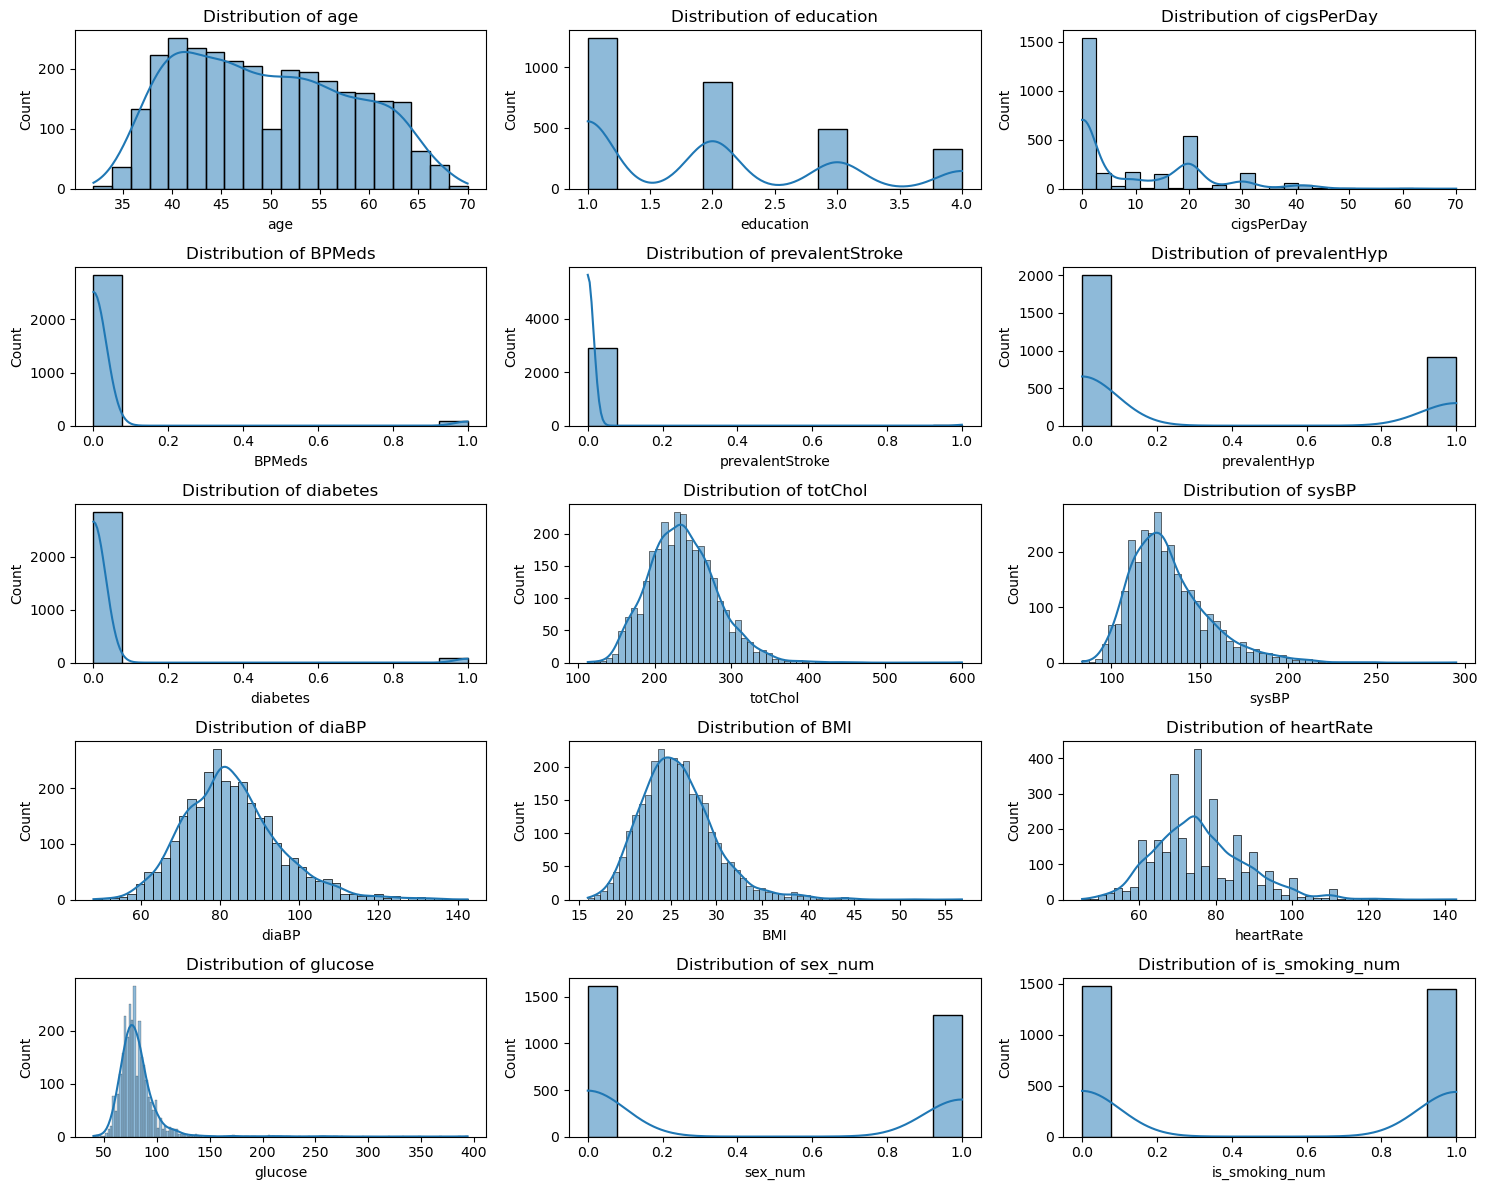

In [17]:
num_cols = df.select_dtypes(include='number').columns.tolist()

if 'TenYearCHD' in num_cols:
    num_cols.remove('TenYearCHD')

rows = (len(num_cols) + 2) // 3
fig, axs = plt.subplots(rows, 3, figsize=(15, 12))
axs = axs.flatten()

for ax, col in zip(axs, num_cols):
    sns.histplot(df[col], ax=ax, kde=True)
    ax.set_title(f'Distribution of {col}')

for ax in axs[len(num_cols):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


Age shows nearly uniform distribution across age groups, indicating that the dataset includes a balanced number of patients from different age ranges.

CigsPerDay is right-skewed, indicating many non-smokers or light smokers and a smaller group of heavy smokers.

Other Quantitative variables shows normal distribution.

To understand which numeric variables are most correlated with our target variable TenYearCHD, I calculate correlation coefficients specifically against this target.

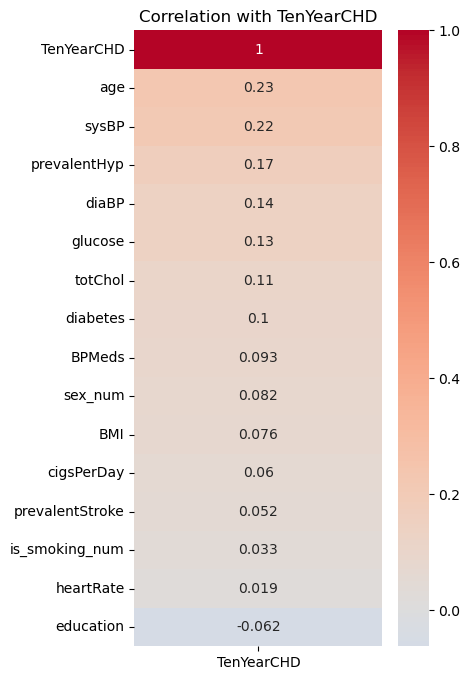

In [18]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_cols].corr()
target_corr = corr_matrix['TenYearCHD'].sort_values(ascending=False)

plt.figure(figsize=(4, 8))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation with TenYearCHD')
plt.show()

The highest positive correlation observed is 0.23, indicating a weak to moderate direct relationship with CHD risk.

Most  correlations are quite low, with the smallest positive value at 0.019, suggesting that many features have only a minor linear association with the target.

Overall, the correlations suggest that no single variable strongly predicts the 10-year risk of CHD on its own.

Boxplots grouped by CHD help to compare how these variables differ between patients with and without 10-year coronary heart disease, highlighting shifts in medians, spread, and potential outliers.

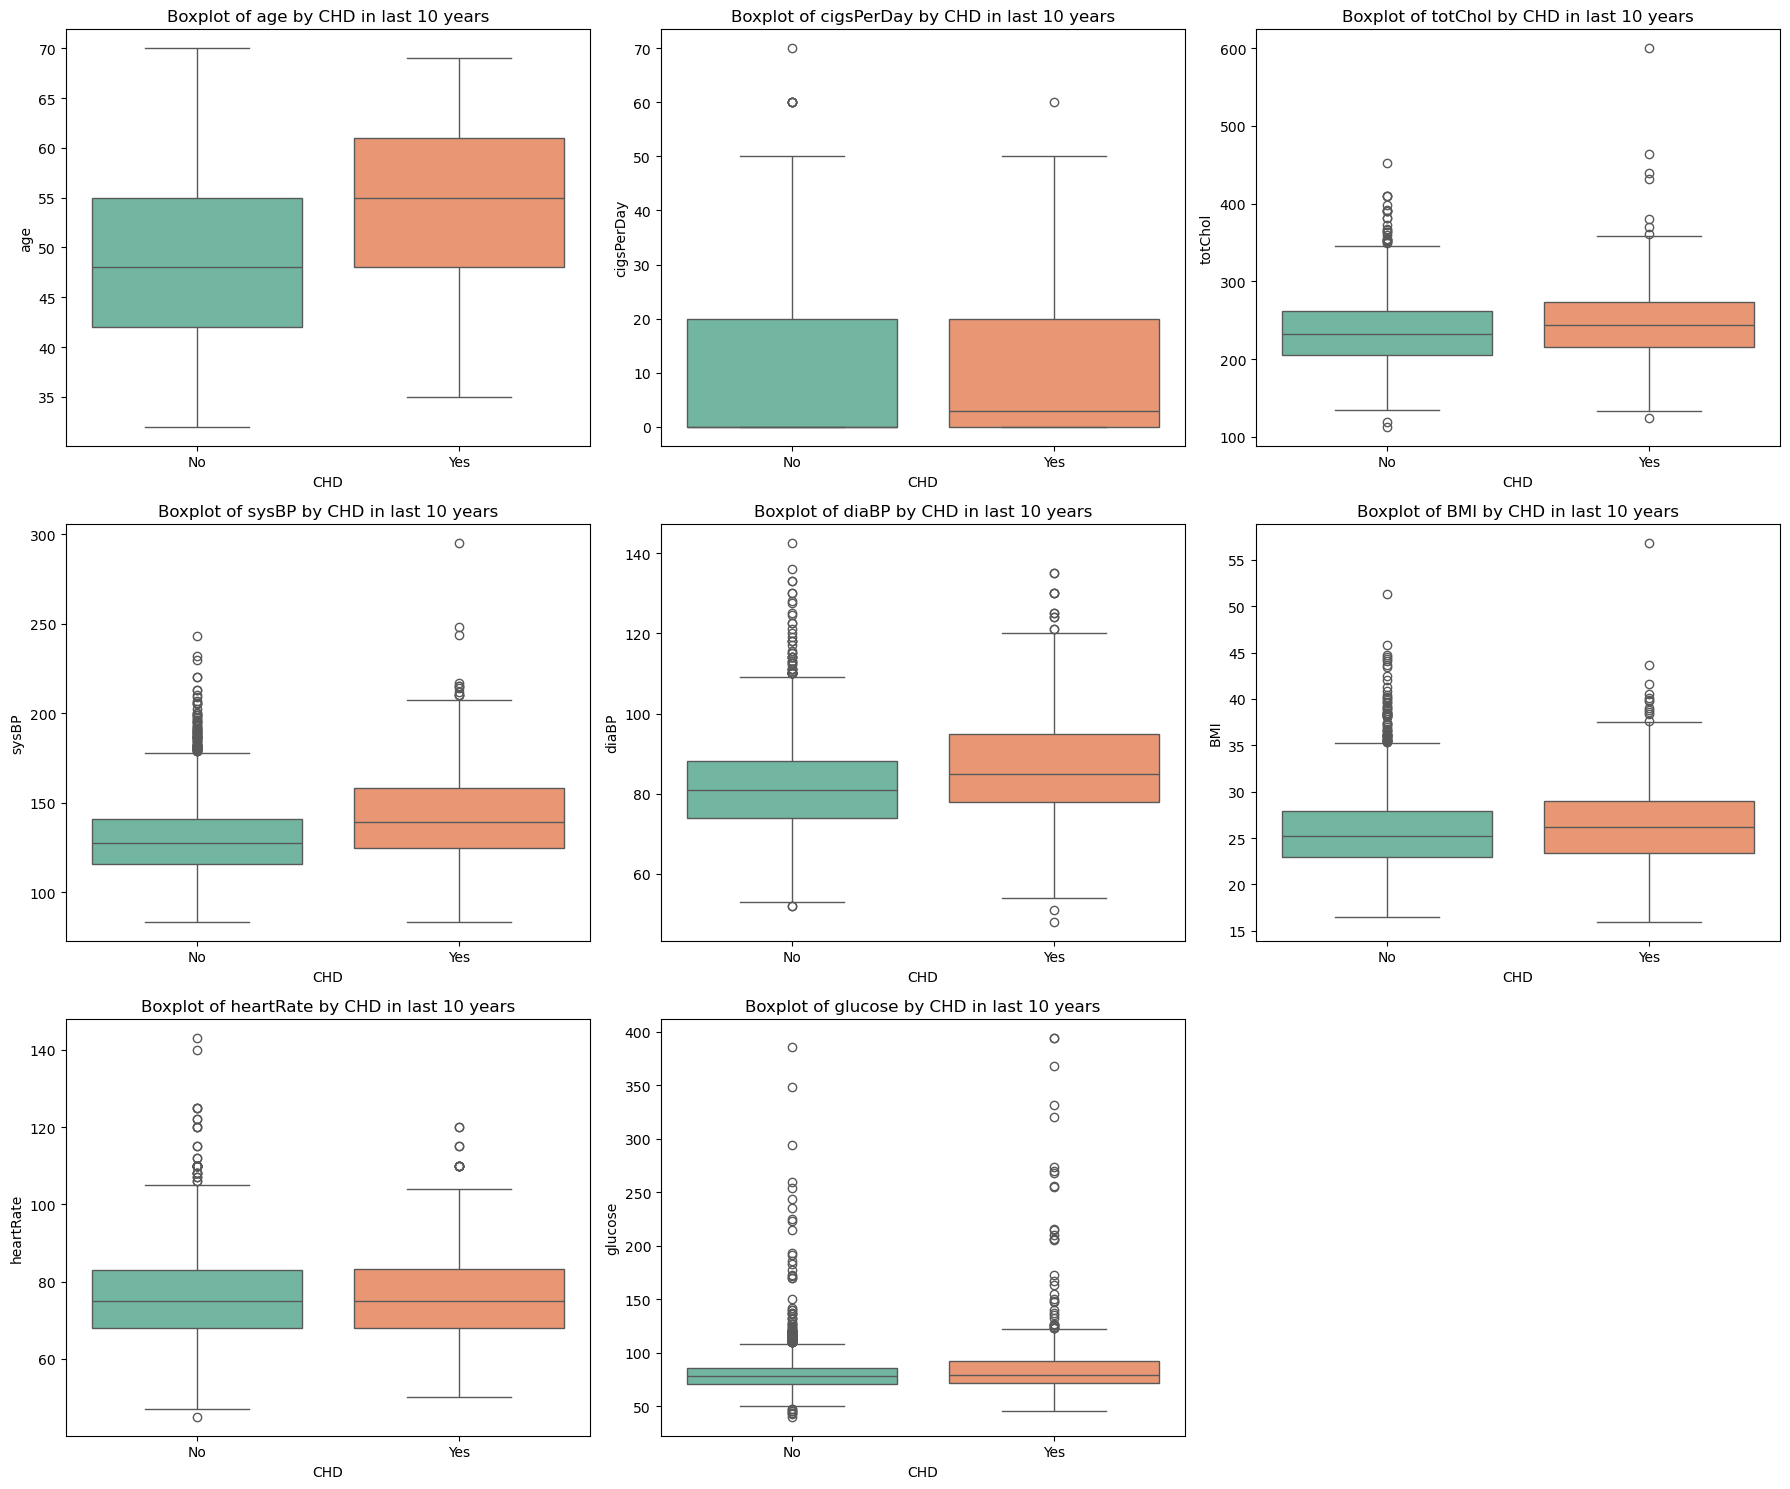

In [19]:
quantitative_vars = [
    'age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP',
    'BMI', 'heartRate', 'glucose'
]

cols = 3
rows = (len(quantitative_vars) + cols - 1) // cols 

fig, axs = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axs = axs.flatten()

for ax, var in zip(axs, quantitative_vars):
    sns.boxplot(x='CHD', y=var, data=df, palette='Set2', ax=ax, hue='CHD', legend=False)
    ax.set_title(f'Boxplot of {var} by CHD in last 10 years')

for ax in axs[len(quantitative_vars):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


It's important to note that there are no extreme outliers present.

 This suggests that the data is relatively clean and does not contain significant anomalies in these key health indicators.

## Modeling

Since each attribute is a potential risk factor, I  will use all of the variables in the model.

In [20]:
features = ['age', 'education', 'sex_num', 'is_smoking_num', 'cigsPerDay',
            'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes',
            'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
target = 'TenYearCHD'

Now I will split my data into a train set and a test set.

In [21]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

I will fit a logistic regression model.

In [22]:
model = LogisticRegression(max_iter=5000, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=5000)

For classification evaluation, I will use the confusion matrix,
which provides a detailed breakdown of true positives, true negatives, false positives, and false negatives.

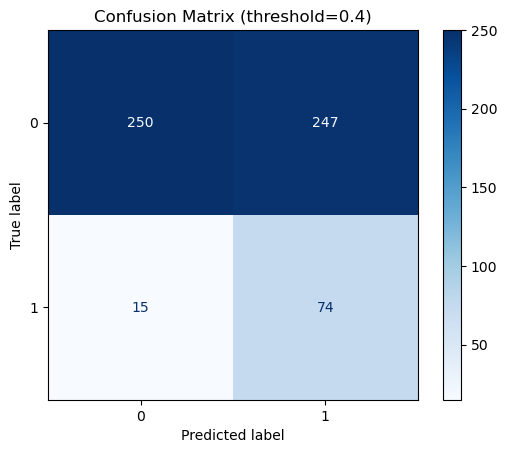

Precision: 0.231
Recall: 0.831


In [23]:
probs = model.predict_proba(X_test)[:, 1]

threshold = 0.4
y_pred = (probs >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (threshold={threshold})")
plt.show()

precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Model Performance at Threshold = 0.4

Lowering the threshold to 0.4 increases recall significantly, allowing the model to identify more true positive cases of CHD. This is important in a medical context where missing positive cases can have serious consequences. Prioritizing recall ensures that fewer at-risk individuals are overlooked.

Now let's interpret the coefficients.

In [24]:
coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coefs)

            Feature  Coefficient
6   prevalentStroke     0.949279
2           sex_num     0.403025
7      prevalentHyp     0.257234
3    is_smoking_num     0.244116
0               age     0.065292
5            BPMeds     0.064726
4        cigsPerDay     0.016508
10            sysBP     0.013698
14          glucose     0.009695
12              BMI     0.007898
9           totChol     0.002034
13        heartRate    -0.004718
11            diaBP    -0.008040
1         education    -0.062307
8          diabetes    -0.434673


Notably, prevalentStroke has the highest positive coefficient (+1.08), indicating a strong association with CHD risk in the model — even though its linear correlation was weak. This highlights how logistic regression can capture non-obvious relationships.

Other factors with moderate positive influence include being male and smoking. Most features, however, show small or negligible effects.

## Improvements and Recommendations
- Experiment with Different Classification Models
While logistic regression is a strong baseline for binary classification, I could have explored other models such as Random Forest, Gradient Boosting, or Support Vector Machines. These models may capture more complex relationships in the data and potentially provide better performance.

- Use SMOTE to Address Class Imbalance
The dataset was balanced using class_weight='balanced', which adjusts the importance of each class during training without altering the dataset itself. An alternative would be to apply SMOTE, which creates synthetic examples of the minority class and can improve model training by preserving all available data.

- Use K-Fold Cross-Validation for Threshold Selection
The classification threshold was selected based on performance on the test set, which risks overfitting. A better approach would be to use k-fold cross-validation on the training data to tune the threshold more reliably. This method helps ensure that the threshold generalizes well and is not biased by a single split.